In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression as LR
from keras.datasets import mnist
import itertools
import codecs

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action = 'ignore', category = FutureWarning)

Using TensorFlow backend.
/home/killerqueen/.pyenv/versions/3.6.7/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/killerqueen/.pyenv/versions/3.6.7/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/killerqueen/.pyenv/versions/3.6.7/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home

In [2]:
def factorial(n):
    if n == 0:
        return 1
    elif n > 0:
        return n*factorial(n - 1)
    else:
        print("sth wrong")

In [3]:
# top-k labelling
def topk_label(probas, s_cls, k):
    l_indexes = probas.argsort()[::-1][:k]
    labels = np.array([s_cls[i] for i in l_indexes])
    return labels

In [4]:
# labelling and evaluating them
def topk_scls_eval(k, classes, orig_A, lim_A):
    s_cls = classes

    # extract dataset of chosen classes
    trn_imgs = [img for i, img in enumerate(train_imgs) if train_labels[i] in s_cls]
    trn_labels = [label for label in train_labels if label in s_cls]
    tst_imgs = [img for i, img in enumerate(test_imgs) if test_labels[i] in s_cls]
    tst_labels = [label for label in test_labels if label in s_cls]

    # generate an annotator
    a1_model = LR().fit(trn_imgs[:orig_A], trn_labels[:orig_A])
    a1_proba = a1_model.predict_proba(trn_imgs[orig_A:orig_A + lim_A])

    # entropy labelling
    mul_labels = [topk_label(probas, s_cls, k) for probas in a1_proba]
    
    # labels score evaluation
    score = 0
    for labels, t_label in zip(mul_labels, trn_labels[orig_A:orig_A + lim_A]):
        for l in labels:
            if (l == t_label):
                score += 1

    m_labels = []
    for labels in mul_labels:
         [m_labels.append(l) for l in labels]                
                    
    return (len(m_labels)/lim_A, score*100/len(m_labels), score*100/lim_A)

In [5]:
# loading MNIST
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_imgs = np.array([x.ravel() for x in train_images])
test_imgs = np.array([y.ravel() for y in test_images])

img_SIZE = train_images.shape[1]*train_images.shape[2]

In [8]:
# main experiment
classes = [i for i in range(10)]
orig_A1, lim_A1 = 2000, 2000

fact_10 = factorial(10)

lqual_mnist1 = []
lqual_mnist2 = []
lqual_mnist3 = []
lqual_mnist4 = []

# from top-1 (ord) to top-4
for k in range(1, 5):
    mnist_evals = []
    for i in range(2, 5):
        a, b, c = 0, 0, 0
        if (i == 10):
            sample_lnum, sample_lqual, sample_lqual2 = topk_scls_eval(k, classes, orig_A1, lim_A1)
            mnist_evals.append((sample_lnum, sample_lqual, sample_lqual2))
        else:
            combi_ni = fact_10//(factorial(i)*factorial(10 - i))
            for scls in itertools.combinations(classes, i):
                sample_lnum, sample_lqual, sample_lqual2 = topk_scls_eval(k, list(scls), orig_A1, lim_A1)
                a += sample_lnum
                b += sample_lqual
                c += sample_lqual2
            mnist_evals.append((a/combi_ni, b/combi_ni, c/combi_ni))

    if (k == 1):
        lqual_mnist1 = [e[1] for e in mnist_evals]
    elif (k == 2):
        lqual_mnist2 = [e[1] for e in mnist_evals]
    elif: (k == 3):
        lqual_mnist3 = [e[1] for e in mnist_evals]
    else:
        lqual_mnist4 = [e[1] for e in mnist_evals]

In [14]:
lqual_mnist1 = [97.91555555555557, 95.70083333333339, 93.45857142857146]

In [15]:
lqual_mnist2 = [50.0, 49.57270833333334, 49.03583333333334]

In [16]:
lqual_mnist3 = [50.0, 33.33333333333339, 25.0]

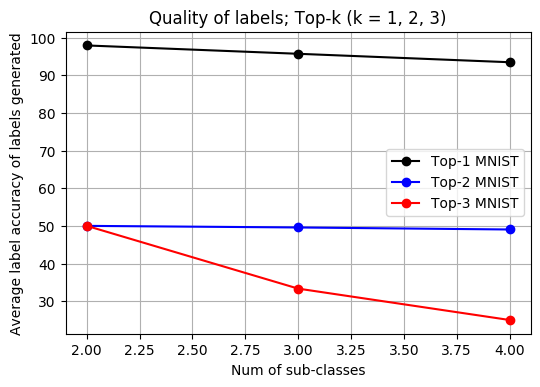

In [18]:
plt.figure(dpi = 100)
plt.title("Quality of labels; Top-k (k = 1, 2, 3)")
plt.plot([i for i in range(2, 5)], lqual_mnist1, marker = "o", color = "k", label = "Top-1 MNIST")
plt.plot([i for i in range(2, 5)], lqual_mnist2, marker = "o", color = "b", label = "Top-2 MNIST")
plt.plot([i for i in range(2, 5)], lqual_mnist3, marker = "o", color = "r", label = "Top-3 MNIST")
plt.xlabel("Num of sub-classes")
plt.ylabel("Average label accuracy of labels generated")	
plt.legend(loc = "best")
plt.grid(True)
plt.savefig("topk_labels-acc_test2.pdf")